In [98]:
# %reload_ext autoreload
# %autoreload 2

import cPickle, os, sys
import random
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

# Importing documents

In [99]:
#Thomas data folder 
# DATA_FOLDER='/Users/thomaspalomares/Desktop/Stanford/RA/multisentences/data/'
#Tanya data folder
# DATA_FOLDER='/Users/tanyaberardini/Desktop/DeepDive/data/'
DATA_FOLDER='arabidopsis_data/'

In [100]:
import json

In [101]:
# name_file_to_parse='pmc/round2/PMC_round_2'
name_file_to_parse='pmc/round1/output_plant'
# #May have to be modified to conserve correct doc_ids (in particular, write in different txt files)
nb_lines=0
nb_error_parsing=0
with open(DATA_FOLDER+name_file_to_parse+'.json', 'rb') as json_file:
    with open(DATA_FOLDER+name_file_to_parse + '.text', 'wb') as text_write:
        docs={}
        for line in json_file:
            nb_lines+=1
            doc_id_read=str(json.loads(line)['doc-id'].encode('utf-8').strip())
#             try:
            #Because this doc is too big
            if doc_id_read=='10.1093.jxb.eru198':
                if random.random() <0.5:
                    doc_id_read += '_1'
                else:
                    doc_id_read += '_2'
            if doc_id_read in docs:
                docs[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
            else:
                docs[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#                 text_write.write(unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore'))
#             except:
#                 nb_error_parsing +=1
#                 print "error parsing"
print nb_lines
print nb_error_parsing

5917
0


In [102]:
# # pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences_round_2'
# pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences'
# sents=[]
# count_loop=0
# parser_sent = SentenceParser()
# try:
#     with open(pkl_f, 'rb') as f:
#         sents = cPickle.load(f)
# except:
#     print"parsing data"
#     for doc_id_loop in docs:
#         count_loop+=1
#         print count_loop
#         for j in parser_sent.parse(docs[doc_id_loop], doc_id=doc_id_loop):
#             sents.append(j)
#     with open(pkl_f, 'w+') as f:
#         cPickle.dump(sents, f)

In [103]:
# # Brief code to merge round1 and round2 data.
#Not great currently, to be improved with try and except.

with open(DATA_FOLDER+'pmc/pickle/pkl_sentences', 'rb') as f:
    sents1=cPickle.load(f)
    
with open(DATA_FOLDER+'pmc/pickle/pkl_sentences_round_2', 'rb') as f:
    sents2=cPickle.load(f)

sents = sents1 + sents2


In [104]:
print len(sents)
print sents[0]

62655
Sentence(words=[u'PROTEIN', u'TARGETING', u'TO', u'STARCH', u'Is', u'Required', u'for', u'Localising', u'GRANULE-BOUND', u'STARCH', u'SYNTHASE', u'to', u'Starch', u'Granules', u'and', u'for', u'Normal', u'Amylose', u'Synthesis', u'in', u'Arabidopsis', u'.'], lemmas=[u'PROTEIN', u'TARGETING', u'to', u'STARCH', u'be', u'require', u'for', u'localise', u'granule-bound', u'starch', u'synthase', u'to', u'Starch', u'Granules', u'and', u'for', u'normal', u'Amylose', u'synthesis', u'in', u'Arabidopsis', u'.'], poses=[u'NNP', u'NNP', u'TO', u'NNP', u'VBZ', u'VBN', u'IN', u'VBG', u'JJ', u'NN', u'NN', u'TO', u'NNP', u'NNPS', u'CC', u'IN', u'JJ', u'NNP', u'NN', u'IN', u'NNP', u'.'], dep_parents=[2, 6, 4, 2, 6, 0, 11, 11, 11, 11, 6, 14, 14, 11, 6, 19, 19, 19, 6, 21, 19, 6], dep_labels=[u'compound', u'nsubjpass', u'case', u'nmod', u'auxpass', u'ROOT', u'case', u'amod', u'amod', u'compound', u'nmod', u'case', u'compound', u'nmod', u'cc', u'case', u'amod', u'compound', u'conj', u'case', u'nmod', 

In [105]:
sents_tot = sents1 + sents2

In [106]:
###BRIEF TEST TO BE REMOVED
# sents=sents_tot[0:1000]
# print len(sents)
# print sents[0]

# Candidate mention Extraction

## Gene extraction

In [107]:
#What is the exact schema of genes ?
genes=[]
for row_genes in [line.rstrip().split('\t') for line in open(DATA_FOLDER + '/dicts/list_genes.txt')]:
    for gene in row_genes:
        genes.append(gene)
        
#Removing blacklist_words
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
genes_filtered = [x.lower() for x in genes if x.lower() not in blacklist_words]

#Adding alleles possibilities (only the longest match is kept anyway)
genes_with_alleles_1 = ["_ " + x + " _ - " + str(i) for x in genes_filtered for i in range(10)]
genes_with_alleles_1_bis = ["_ " + x + " _ -" + str(i) for x in genes_filtered for i in range(10)]
genes_with_alleles_2 = ["_ " + x + " _ - _ " + str(i) + " _" for x in genes_filtered for i in range(10)]
genes_with_alleles_3 = [x + " - " + str(i) for x in genes_filtered for i in range(10)]



genes_tot= genes_filtered + genes_with_alleles_1+ genes_with_alleles_1_bis + genes_with_alleles_2 + genes_with_alleles_3

In [108]:
# gene_dm = DictionaryMatch(label='GeneName', dictionary=genes_filtered, ignore_case=False)
gene_dm = ConcatSingleDictionaryMatch(label='GeneName', dictionary=genes_tot, ignore_case=True)

The dictionary match should provide fairly high recall, but we may still miss some candidates. We know that gene names are named nouns and are often all uppercase. Let's use DDLite's compositional matcher operations to handle this. First, we'll write a matcher to find all nouns using the parts-of-speech tags. Then, we'll use a filter to find uppercase sequences. Finally, we'll use a filter to make sure each match has at least 3 characters. We pass noun_rm to up_rm, and up_rm to the final filter to compose them with each other.

In [109]:
noun_regex = RegexNgramMatch(label='Nouns', regex_pattern=r'[A-Z]?NN[A-Z]?', ignore_case=True, match_attrib='poses')
up_regex = RegexFilterAll(noun_regex, label='Upper', regex_pattern=r'[A-Z]+([0-9]+)?([A-Z]+)?([0-9]+)?$', ignore_case=False, match_attrib='words')
multi_regex = RegexFilterAll(up_regex, label='Multi', regex_pattern=r'[a-z0-9]{3,}', ignore_case=True)

Since we want matches both from the dictionary and the uppercase-noun-phrase-matcher we just built, we'll use the union object to create a matcher for both.

In [110]:
#The previous regexes seem to catch many patterns not wanted (like 'and' or others), let's ignore it for now and we can add it when we'll work on recall
# GM = Union(gene_dm, multi_regex)
GM=gene_dm

## Pheno extraction

In [111]:
# Schema is: HPO_ID | NAME | TYPE (exact, lemma)
phenos_deepdive = [line.rstrip().split('\t')[1] for line in open(DATA_FOLDER + '/dicts/pheno_terms.tsv')]
phenos_arabidopsis = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/list_phenotypes_arabidopsis_filtered.txt')]
phenos_worm_variants = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/worm_variants_unix.txt')]
phenos_all_eq_dict = [pheno.strip() for line in open(DATA_FOLDER + 'dicts/phenotypes_all_eq_dict.txt') for pheno in line.rstrip().split(';')]
phenos_manual = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/phenotypes_manual.txt')]

phenos_tot = phenos_deepdive + phenos_arabidopsis + phenos_worm_variants + phenos_all_eq_dict + phenos_manual

#Removing the phenotypes that are in the blacklist.
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
phenos_tot_filtered = [x.lower() for x in phenos_tot if x.lower() not in blacklist_words]

PM = DictionaryMatch(label='PhenoName', dictionary=phenos_tot_filtered)

In [112]:
#Function to read obo files (from the obo foundry, for PATO, CHEBI and PO)
"""
A constant-space parser for the GeneOntology OBO v1.2 format

Version 1.0
"""
from __future__ import with_statement
from collections import defaultdict

__author__    = "Uli Koehler"
__copyright__ = "Copyright 2013 Uli Koehler"
__license__   = "Apache v2.0"

def processGOTerm(goTerm):
    """
    In an object representing a GO term, replace single-element lists with
    their only member.
    Returns the modified object as a dictionary.
    """
    ret = dict(goTerm) #Input is a defaultdict, might express unexpected behaviour
    for key, value in ret.iteritems():
        if len(value) == 1:
            ret[key] = value[0]
    return ret

def parseGOOBO(filename):
    """
    Parses a Gene Ontology dump in OBO v1.2 format.
    Yields each 
    Keyword arguments:
        filename: The filename to read
    """
    with open(filename, "r") as infile:
        currentGOTerm = None
        for line in infile:
            line = line.strip()
            if not line: continue #Skip empty
            if line == "[Term]":
                if currentGOTerm: yield processGOTerm(currentGOTerm)
                currentGOTerm = defaultdict(list)
            elif line == "[Typedef]":
                #Skip [Typedef sections]
                currentGOTerm = None
            else: #Not [Term]
                #Only process if we're inside a [Term] environment
                if currentGOTerm is None: continue
                key, sep, val = line.partition(":")
                currentGOTerm[key].append(val.strip())
        #Add last term
        if currentGOTerm is not None:
            yield processGOTerm(currentGOTerm)

In [113]:
po_ontology = []
# test_count=0
for elt in parseGOOBO(DATA_FOLDER + 'dicts/po.obo'):
#     test_count+=1
#     if test_count < 10:
    po_ontology.append(elt['name'])
    
chebi_ontology =[]
for elt in parseGOOBO(DATA_FOLDER + 'dicts/chebi.obo'):
    chebi_ontology.append(elt['name'])
    
pato_ontology =[]
for elt in parseGOOBO(DATA_FOLDER + 'dicts/pato.obo'):
    pato_ontology.append(elt['name'])

# Relation Extraction

For each sentence, we extract a candidate relation for each pair (gene, phenotype) appearing in the sentence.

In [114]:
R = Relations(sents, GM, PM)

In [115]:
R[5].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 Consistent with these localisations , the amount of granule-bound PTST detected in wild-type Arabidopsis in is small compared to stromal PTST .

In [116]:
# test_sent=9
# for i in range(len(R[test_sent].dep_parents)):
#     print i, R[test_sent].words[i], R[test_sent].dep_parents[i], R[test_sent].poses[i]

In [117]:
# R.dump_candidates('pickle/relations.pkl')

# ddlite Model

We create a ddlite model from the previous candidates, on which we will extract features, define labeling functions and learn a model. 

In [118]:
DDL = DDLiteModel(R)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 95957 features for each of 3908 mentions


# Building a gold ground truth

We label here a certain amount of sentences that will allow us to evaluate our model.

In [119]:
#Importing previous mentions labeled
tags_file = DATA_FOLDER + 'tags/tags_fccb81915ae086e3'
first_line=True
tags_list=[]
with open(tags_file, 'rb') as f:
    for line in f:
        if first_line:
            header=line.rstrip().split('\t')
            first_line=False
        else:
            res={}
            for i, item in enumerate(line.rstrip().split('\t')):
                res[header[i]]=item
            res['sent_id']=int(res['sent_id'])
            res['e1_idxs'] = map(int, res['e1_idxs'][1:-1].split(','))
            res['e2_idxs'] = map(int, res['e2_idxs'][1:-1].split(','))
            tags_list.append(res)

In [120]:
print len(tags_list)
print tags_list[0]

200
{'e2_idxs': [7], 'wrong gene': '\\N', 'e1_label': 'GeneName', 'probability': '', 'e2_label': 'PhenoName', 'sent_id': 132, 'multiple mutant': '\\N', 'is_correct': 'false', 'one word phenotype not useful': '\\N', 'words': '["However", ",", "the", "rates", "of", "germination", "and", "cotyledon", "greening", "among", "_", "abi4", "_", ",", "WT", "and", "_", "OE-ABI4", "_", "were", "comparable", "when", "we", "used", "medium", "supplemented", "with", "exogenous", "GA.", "."]', 'wrong phenotype': 'true', 'e1_idxs': [11], 'doc_id': '10.1371.journal.pgen.1003577', 'overlapping gene and phenotype': '\\N', 'ext_id': '430'}


In [129]:
#Finding the index in DDL of our labeled data
def func_DDL_index_with_tag(DDL_var, tag_var):
#     count=0
    for i in range(DDL.num_candidates()):
        if DDL.C[i].doc_id==tag_var['doc_id']:
            if DDL.C[i].sent_id==tag_var['sent_id']:
                if DDL.C[i].e1_idxs==tag_var['e1_idxs']:
                    if DDL.C[i].e2_idxs==tag_var['e2_idxs']:
#                         count+=1
                        return DDL.C[i].uid
    return -1
#     if count >1:
#         print 'WEIRD: more than one element found'

In [134]:
#Creating the corresponding gold file
gold =[]
gold_uids = []
for i in range(len(tags_list)):
    uid_idx = func_DDL_index_with_tag(DDL, tags_list[i])
    if uid_idx > -1:
        if tags_list[i]['is_correct']=='false':
            gold.append(-1)
            gold_uids.append(uid_idx)
        if tags_list[i]['is_correct']=='true':
            gold.append(1)
            gold_uids.append(uid_idx)
            
DDL.update_gt(gold, uids=gold_uids)
DDL.set_holdout(validation_frac=0.8)

../ddlite.py:592: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.validation = h[ : np.floor(validation_frac * len(h))]
../ddlite.py:593: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.test = h[np.floor(validation_frac * len(h)) : ]


In [135]:
gold

[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1]

In [136]:
#Yellow: gene. Blue: phenotype
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [137]:
# DDL.add_mindtagger_tags()
# DDL.get_ground_truth()

In [152]:
test_ext_id=2110
for i in range(len(R)):
    if R[i].sent_id == R[test_ext_id].sent_id and R[i].doc_id == R[test_ext_id].doc_id:
        print R[i].e1_idxs, R[i].e2_idxs, ' '.join(R[i].words)
    if 'rlsb' in [R[i].words[j] for j in R[i].e1_idxs]:
        print i

2077
2079
2080
2082
2083
2094
2095
2098
2099
2103
2107
2108
2109
[42] [25] However , the finding that greatly reduced Rubisco within the _ raf_1 mutant leaves had no observable effect on any other plastid-encoded proteins represents a clear difference from the effects observed in lower regions of the _ rlsb _ -1 / _ rlsb _ -2 leaves .
2110
[37] [25] However , the finding that greatly reduced Rubisco within the _ raf_1 mutant leaves had no observable effect on any other plastid-encoded proteins represents a clear difference from the effects observed in lower regions of the _ rlsb _ -1 / _ rlsb _ -2 leaves .
2111
2112
2113
2114


# Writing labeling functions

We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an Candidate object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

In [139]:
count=0
for relation in R:
    if 'loss' in relation.words:
        count+=1
        if count <10:
            relation.render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The Arabidopsis _ ss4 _ mutant phenotype is characterised by the loss of starch in younger leaves , and chloroplasts of older leaves contain one large starch granule .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 Taken together , our data indicate that loss of HEN2 results in the accumulation of short transcripts derived from mRNA regions , 3 extended transcripts , incompletely spliced mRNA transcripts , and excised introns .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 However , we were not able to obtain double _ mtr4 hen2 _ mutants , signifying that simultaneous loss of both AtMTR4 and HEN2 is lethal .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 However , we were not able to obtain double _ mtr4 hen2 _ mutants , signifying that simultaneous loss of both AtMTR4 and HEN2 is lethal .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 However , we were not able to obtain double _ mtr4 hen2 _ mutants , signifying that simultaneous loss of both AtMTR4 and HEN2 is lethal .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 _ MDA1 _ loss of function alters plant development , leading to defective chloroplast function and gene expression , early flowering , reduced plant growth and pale pigmentation , together with increased tolerance to salt and osmotic stress , and altered responses to sugars and ABA .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 _ MDA1 _ loss of function alters plant development , leading to defective chloroplast function and gene expression , early flowering , reduced plant growth and pale pigmentation , together with increased tolerance to salt and osmotic stress , and altered responses to sugars and ABA .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The deleted amino acids belong to the predicted domain with GTPase activity , where the deletion of the conserved Lys362 has been shown to modify the localization of _ FZL _ , with the consequent loss of function of the FZL protein ( ) ; therefore , the molecular alteration found in the _ fzl - _ L_er _ mutant is compatible with the severe phenotype observed .

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 The deleted amino acids belong to the predicted domain with GTPase activity , where the deletion of the conserved Lys362 has been shown to modify the localization of _ FZL _ , with the consequent loss of function of the FZL protein ( ) ; therefore , the molecular alteration found in the _ fzl - _ L_er _ mutant is compatible with the severe phenotype observed .

In [140]:
#Here, idx_mention refers to 0 or 1, whether we consider the gene or phenotype
def post_window(r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = len(r.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def pre_window (r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def stopper(r, idx_mention, stop):
    return stop in [r.lemmas[i] for i in r.all_idxs[idx_mention]]

#If the word mutation is before gene:
def LF_mutation_gene_t(r):
    if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    else:
        if 'mutant' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
            return 1
        else:
            return 0
#If the word mutation is before pheno:
def LF_mutation_pheno_t(r):
    if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[1]]:
        return 1
    else:
        if 'mutant' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[1]]:
            return 1
        else:
            return 0
#If phenotype just before gene, certainly wrong
def LF_pheno_before_gene_f(r):
    res=False
    for i in r.all_idxs[1]:
        if pre_window(r, 0, r.words[i], n=1):
            res=True
    if res:
        return -1
    else:
        return 0
#If phenotype is only a verb, likely to be false
def LF_pheno_only_verb_f(r):
    if len(r.all_idxs[1])==1 and r.poses[r.all_idxs[1][0]][0:2] == 'VB':
        return -1
    else:
        return 0
#if phenotype only one word, likely to be false (except lethal)
def LF_pheno_only_one_word_f(r):
    if len(r.all_idxs[1])==1 and r.lemmas[r.all_idxs[1][0]] != 'lethal':
        return -1
    else:
        return 0
#if gene and phenotype have words in common, very likely to be false
def LF_gene_pheno_words_in_common_f(r):
    if len([val for val in r.all_idxs[0] if val in r.all_idxs[1]]) >0:
        return -1
    else:
        return 0
#if gfp at the end of a gene, likely to be false
def LF_gene_ends_in_gfp_f(r):
    if len(r.all_idxs[0])==1 and len(r.mention1()[0]) >2 and r.mention1()[0][-3:].lower() == 'gfp':
        return -1
    else:
        return 0
#If double mutant around the gene name, more likely true:
def LF_double_mutant_gene_t(r):
    if (post_window(r, 0, 'double', 3) and post_window(r, 0, 'mutant', 3)) or (pre_window(r, 0, 'double', 3) and pre_window(r, 0, 'mutant', 3)):
        return 1
    else:
        return 0
#If mutant around the gene name, more likely true:
def LF_mutant_gene_t(r):
    if post_window(r, 0, 'mutant', 3) or pre_window(r, 0, 'mutant', 3):
        return 1
    else:
        return 0
#'In WT' is generally not a phenotype
def LF_in_WT_pheno_f(r):
    if len(r.all_idxs[1])==1 and r.words[r.all_idxs[1][0]] == 'WT' and pre_window(r,1, 'in', 1):
        return -1
    else:
        return 0
#If the sentence mentions "loss of [GENE]
def LF_loss_of_gene_t(r):
    if 'loss' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    if post_window(r, 0, 'loss', 3) or pre_window(r, 0, 'loss', 3):
        return 1
    else:
        return 0    
#if the word 'defect' is around the gene
def LF_defect_of_gene_t(r):
    if 'defect' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]]:
        return 1
    if post_window(r, 0, 'defect', 3) or pre_window(r, 0, 'defect', 3):
        return 1
    else:
        return 0  


In [141]:
LFs= [LF_mutation_gene_t, LF_mutation_pheno_t, LF_pheno_before_gene_f, LF_pheno_only_verb_f, LF_pheno_only_one_word_f, LF_gene_pheno_words_in_common_f, LF_gene_ends_in_gfp_f, LF_double_mutant_gene_t, LF_mutant_gene_t, LF_in_WT_pheno_f, LF_loss_of_gene_t, LF_defect_of_gene_t]
DDL.apply_lfs(LFs, clear=True)

### More analysis on the labeling functions

In [142]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	83.012%
Overlap:	17.579%
Conflict:	9.535%


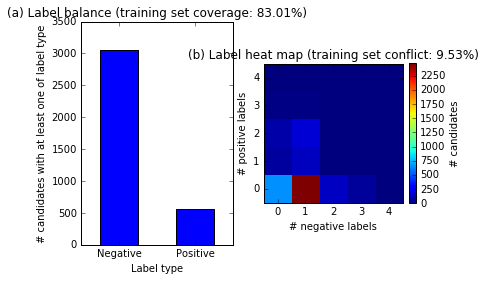

In [143]:
%matplotlib inline
DDL.plot_lf_stats()

In [144]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_pheno_only_one_word_f,9.38%
LF_mutant_gene_t,7.02%
LF_mutation_gene_t,6.40%


In [145]:
DDL.lowest_coverage_lfs(n=15)

Labeling function,Candidate coverage
LF_gene_ends_in_gfp_f,0.00%
LF_in_WT_pheno_f,0.00%
LF_defect_of_gene_t,0.33%
LF_loss_of_gene_t,0.64%
LF_double_mutant_gene_t,0.93%
LF_pheno_only_verb_f,1.26%
LF_mutation_pheno_t,1.70%
LF_mutant_gene_t,10.54%
LF_pheno_before_gene_f,3.57%
LF_gene_pheno_words_in_common_f,3.78%


In [146]:
DDL.lowest_empirical_accuracy_lfs(n=10)

100% accuracy and 0 generalization score are "perfect"


../ddlite.py:562: UserWarning: Dev sets are too small for reliable estimates
  warnings.warn("Dev sets are too small for reliable estimates")


Labeling function,Positive accuracy,Gen. score
LF_mutation_gene_t,0.00% (n=0),0.00 (n=0)
LF_mutant_gene_t,0.00% (n=0),0.00 (n=0)
LF_defect_of_gene_t,0.00% (n=0),0.00 (n=0)
LF_loss_of_gene_t,0.00% (n=0),0.00 (n=0)
LF_mutation_pheno_t,0.00% (n=0),0.00 (n=0)
LF_double_mutant_gene_t,0.00% (n=0),0.00 (n=0)
Labeling function,Negative accuracy,Gen. score
LF_pheno_before_gene_f,0.00% (n=0),0.00 (n=0)
LF_gene_pheno_words_in_common_f,0.00% (n=0),0.00 (n=0)
LF_pheno_only_verb_f,0.00% (n=0),0.00 (n=0)


In [147]:
#Let's have a look at the labeled elements:
DDL.get_labeled_ground_truth(gt='resolve', subset=None)

TypeError: get_labeled_ground_truth() got an unexpected keyword argument 'gt'

In [ ]:
print DDL.lf_matrix

In [ ]:
DDL.C[16]

# Learning

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12,4)
#Try with bias=True, error currently for some reasons
%time DDL.learn_weights(sample=False, maxIter=1000, alpha=0, bias=False, verbose=True, log=True, mu=1e-6)

In [ ]:
%matplotlib inline
DDL.plot_calibration()

In [ ]:
DDL.lf_matrix

# Iterating with labeling functions

In [ ]:
DDL.show_log()

In [ ]:
# DDL.open_mindtagger(width='100%', height=1200)
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

In [ ]:
#ext_id are available from mindtag, we can write quick functions to extract:
#- all candidates in this sentence (from sent_id, match in R)
#- all label functions, from label matrix
R[1020].render()

# Attempt with Multi Sentences

Here we concatenante 2 sentences in a same document, then export all the relations from this new dataset and keep only the candidates that have a "." between them.

In [ ]:
#Function to merge two dependencies path, just a prototype currently, many different possible
#In this function, the "." between the two sentences is placed as the root and the sentences are attached below
def merge_dependency_paths(dep_parent1, dep_parent2):
    res_dep_parents = dep_parent1+dep_parent2
    idx_root_sent1=-1
    for i in range(len(dep_parent1)):
        if dep_parent1[i]==0:
            idx_root_sent1=i
            break
    idx_root_sent2=-1
    for i in range(len(dep_parent2)):
        if dep_parent2[i]==0:
            idx_root_sent2=i
        res_dep_parents[len(dep_parent1)+i]=dep_parent2[i]+len(dep_parent1)
    #Setting the "." between the two sentences as the root
    res_dep_parents[len(dep_parent1)-1]=0
    #Connecting the two previous roots this new root
    res_dep_parents[idx_root_sent1]=len(dep_parent1)
    res_dep_parents[idx_root_sent2+len(dep_parent1)]=len(dep_parent1)
    return res_dep_parents


sents_multi = []
for idx in range(len(sents)-1):
    if sents[idx+1].doc_id == sents[idx].doc_id and sents[idx+1].sent_id == sents[idx].sent_id+1:
        parts = defaultdict(list)
        parts['words']=(sents[idx].words+sents[idx+1].words)
        parts['lemmas']=(sents[idx].lemmas+sents[idx+1].lemmas)
        parts['poses']=(sents[idx].poses+sents[idx+1].poses)
        parts['token_idxs']=(sents[idx].token_idxs+sents[idx+1].token_idxs)
        parts['dep_labels']=(sents[idx].dep_labels+sents[idx+1].dep_labels)
        parts['sent_id']=(sents[idx].sent_id)
        parts['doc_id']=(sents[idx].doc_id)
        parts['text']=(sents[idx].text+' '+ sents[idx+1].text)
        parts['dep_parents']=(merge_dependency_paths(sents[idx].dep_parents, sents[idx+1].dep_parents))
        res_sent = Sentence(**parts)
        sents_multi.append(res_sent)

In [ ]:
print sents[0].words + sents[1].words
print ' '
print sents_multi[0]

In [ ]:
R_multi = Relations(sents_multi, GM, PM)

In [ ]:
R_multi[10].render()
# R[0].render()

In [ ]:
#Filtering and removing 
R_multi.num_feats()

In [ ]:
DDL_multi = DDLiteModel(R_multi)
print "Extracted {} features for each of {} mentions".format(DDL_multi.num_feats(), DDL_multi.num_candidates())

In [ ]:
DDL.w